## 1. Imports & Config.

In [19]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS

data_dir = os.path.join(os.getcwd(), 'data')

obsid = '1342203292'  # observation id

level = 'level2_5'

lambda_um = 500

array = {250: 'PSW', 350: 'PMW', 500: 'PLW'}[lambda_um]

# possible types:
#   extd: extended-source calibrated (MJy/sr)
#   hires: extended-source calibrated, hi-res (Richardson-Lucy deconvolution, MJy/sr)
#   psrc: point-source calibrated (Jy/beam)

type = 'hires'

product = f'{type}{array}'

obs_dir = os.path.join(data_dir, obsid)
level_dir = os.path.join(obs_dir, level)
prod_dir = os.path.join(level_dir, product)

## 2. Load Image Data

In [20]:
# each product directory contains a single .fits file
prod_fnames = os.listdir(prod_dir)
assert len(prod_fnames) == 1, "only one file expected"
assert prod_fnames[0].endswith('.fits'), "file should be in .fits format"

fits_filename = os.path.join(prod_dir, prod_fnames[0])

# open the only file in the directory
hdul = fits.open(fits_filename)  # Header Data Unit list
hdul.info()

Filename: C:\Users\Jonah\PycharmProjects\spire_blasttng_diff\data\1342203292\level2_5\hiresPLW\hspireplw1342203291_25hirespxmp_1462481003485.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     163   ()      
  1  image         1 ImageHDU        49   (1776, 1836)   float64   
  2  cfv           1 ImageHDU        47   (1776, 1836)   float64   
  3  coverage      1 ImageHDU        49   (1776, 1836)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   10R x 1C   [326A]   
  6  HistoryTasks    1 BinTableHDU     46   3R x 4C   [1K, 16A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   25R x 10C   [1K, 18A, 13A, 196A, 1L, 1K, 1L, 47A, 11A, 28A]   


## 3. Plot Images

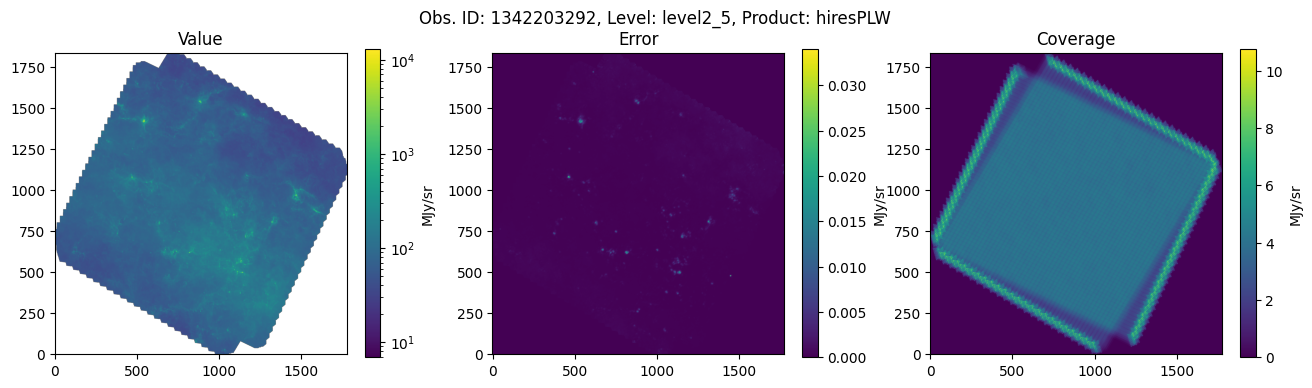

In [21]:
log_norm = colors.LogNorm()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(16, 4))
fig.suptitle(f"Obs. ID: {obsid}, Level: {level}, Product: {product}")

img = hdul[1].data
ax1.set_title("Value")
fig1 = ax1.imshow(img, cmap='viridis', norm=log_norm, origin='lower')
plt.colorbar(fig1, ax=ax1, label="MJy/sr")

error = hdul[2].data
ax2.set_title("Error")
fig2 = ax2.imshow(error, cmap='viridis', origin='lower')
plt.colorbar(fig2, ax=ax2, label="MJy/sr")

coverage = hdul[3].data
ax3.set_title("Coverage")
fig3 = ax3.imshow(coverage, cmap='viridis', origin='lower')
plt.colorbar(fig3, ax=ax3, label="MJy/sr")

plt.show()

# hdul[1].header

In [22]:
rcw92_coord = SkyCoord(ra=229.66292*u.deg, dec=-56.64694*u.deg)

wcs = WCS(fits_filename)

wcs.world_to_pixel(rcw92_coord)

(array(537.40752886), array(1413.06128697))

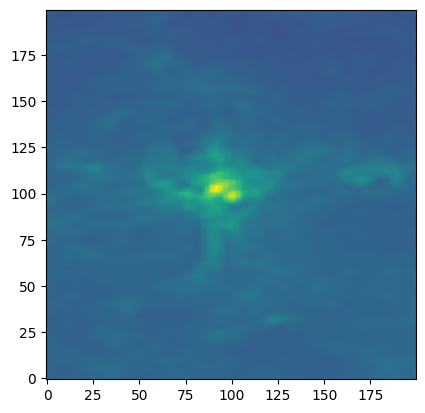

In [53]:
width = 0.5*u.deg

ra_min = rcw92_coord.ra - width/2
ra_max = rcw92_coord.ra + width/2

dec_min = rcw92_coord.dec - width/2
dec_max = rcw92_coord.dec + width/2

x_resolution = 200
y_resolution = 200

x_coords = []
y_coords = []
for dec in np.linspace(dec_min, dec_max, x_resolution):
    for ra in np.linspace(ra_min, ra_max, y_resolution):
        x_coords.append(ra)
        y_coords.append(dec)

rows, cols = wcs.world_to_pixel(SkyCoord(ra=x_coords, dec=y_coords))

out_img = []
for y in range(y_resolution):
    row = []
    for x in range(x_resolution):
        i = y * x_resolution + x
        row.append(img[int(cols[i]), int(rows[i])])
    out_img.append(row)
        

plt.imshow(out_img, cmap='viridis', norm=log_norm, origin='lower')
plt.show()